***DT-Box-Inference Pavel Chigirev, pavelchigirev.com, 2023-2024***

These code examples accompany the series of articles on using trained neural network models as technical indicators in MetaTrader5, using the DT-Box-Inference tool.

Here you can find an [introduction to the series](https://pavelchigirev.com/intro-dt-box-inference/)

**Example 1** Visualising 5 random patterns of class 1. For every bar in pattern dataset we will use middle price (H + L) / 2

Training Data Shape: (137, 43)
Training Labels Shape: (137,)


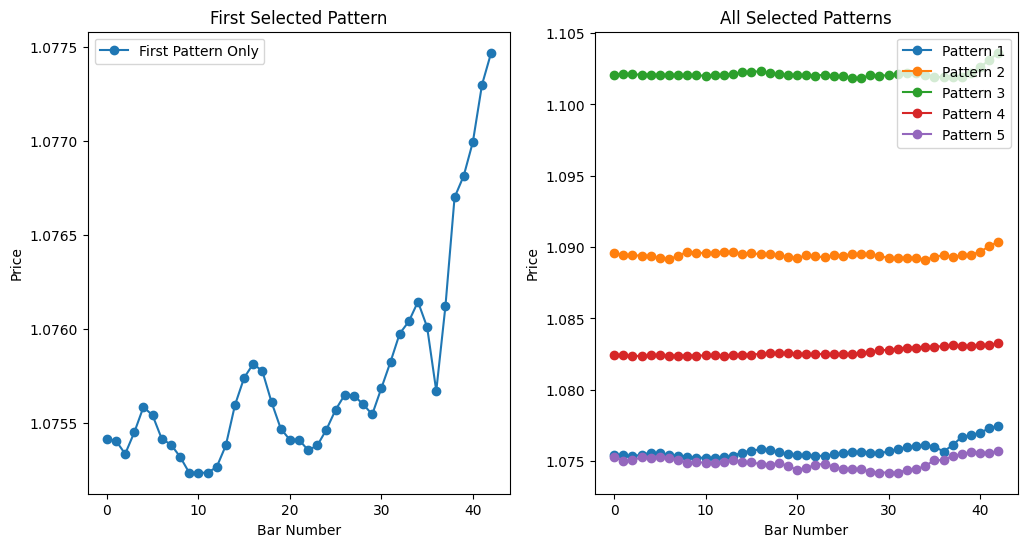

In [ ]:
import os
import re
import numpy as np
import matplotlib.pyplot as plt

def find_dataset_file(postfix):
    escaped_postfix = re.escape(postfix)
    pattern = rf'^dataset_\d{{4}}\.\d{{2}}\.\d{{2}} \d{{2}}\.\d{{2}}\.\d{{2}}_{escaped_postfix}\.csv$'

    matched_files = []

    for filename in os.listdir('.'):
        if re.match(pattern, filename):
            matched_files.append(filename)

    if len(matched_files) == 1:
        return matched_files[0]
    elif len(matched_files) > 1:
        raise Exception("Multiple report files with specified postfix found.")
    else:
        raise Exception("No files with specified postfix found.")

def load_data_from_file(filename):
    data = []
    labels = []
    dataset_len = 0

    with open(filename, 'r') as file:
        for line in file:
            mp_values, class_label, set_len = parse_dataset_line(line)
            if mp_values is not None:
                if dataset_len == 0: dataset_len = set_len
                elif dataset_len != set_len: print("Incorrect set size")
                data.append(np.array(mp_values))
                labels.append(class_label)

    return np.array(data), np.array(labels), dataset_len

def parse_dataset_line(line):
    data_line = line.strip().split('::')
    if len(data_line) == 3:
        ohlc_data_string = data_line[1]
        class_label = int(data_line[2])

        # Extract individual OHLC values
        ohlc_values = []
        entries = ohlc_data_string.split('],[')
        for entry in entries:
            # Extract and convert O, H, L, C values
            d, o, h, l, c = entry.replace('[', '').replace(']', '').replace(' ','').split(',')
            med_price = (float(h) + float(l)) / 2.0
            ohlc_values.append(med_price)
        return ohlc_values, class_label, len(ohlc_values)
    return None, None

filename_training = find_dataset_file("training")
training_data, training_labels, training_len = load_data_from_file(filename_training)

print("Training Data Shape:", training_data.shape)
print("Training Labels Shape:", training_labels.shape)

# For reproducible results
np.random.seed(1)

# Randomly selecting 5 patterns of class 1 from training data
class_1_indices = np.where(training_labels == 1)[0]
selected_indices = np.random.choice(class_1_indices, 5, replace=False)
selected_arrays = training_data[selected_indices]

# Draw selected patterns
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
ax1.plot(selected_arrays[0], marker='o', linestyle='-', label='First Pattern Only')
for idx, array in enumerate(selected_arrays):
    ax2.plot(array, marker='o', linestyle='-', label=f'Pattern {idx+1}')

ax1.set_title('First Selected Pattern')
ax2.set_title('All Selected Patterns')
ax1.set_xlabel('Bar Number')
ax1.set_ylabel('Price')
ax1.legend()
ax2.set_xlabel('Bar Number')
ax2.set_ylabel('Price')
ax2.legend()

plt.show()

**Example 2** Comparison of normalization techniques. ***Run Example 1 first to load the data***

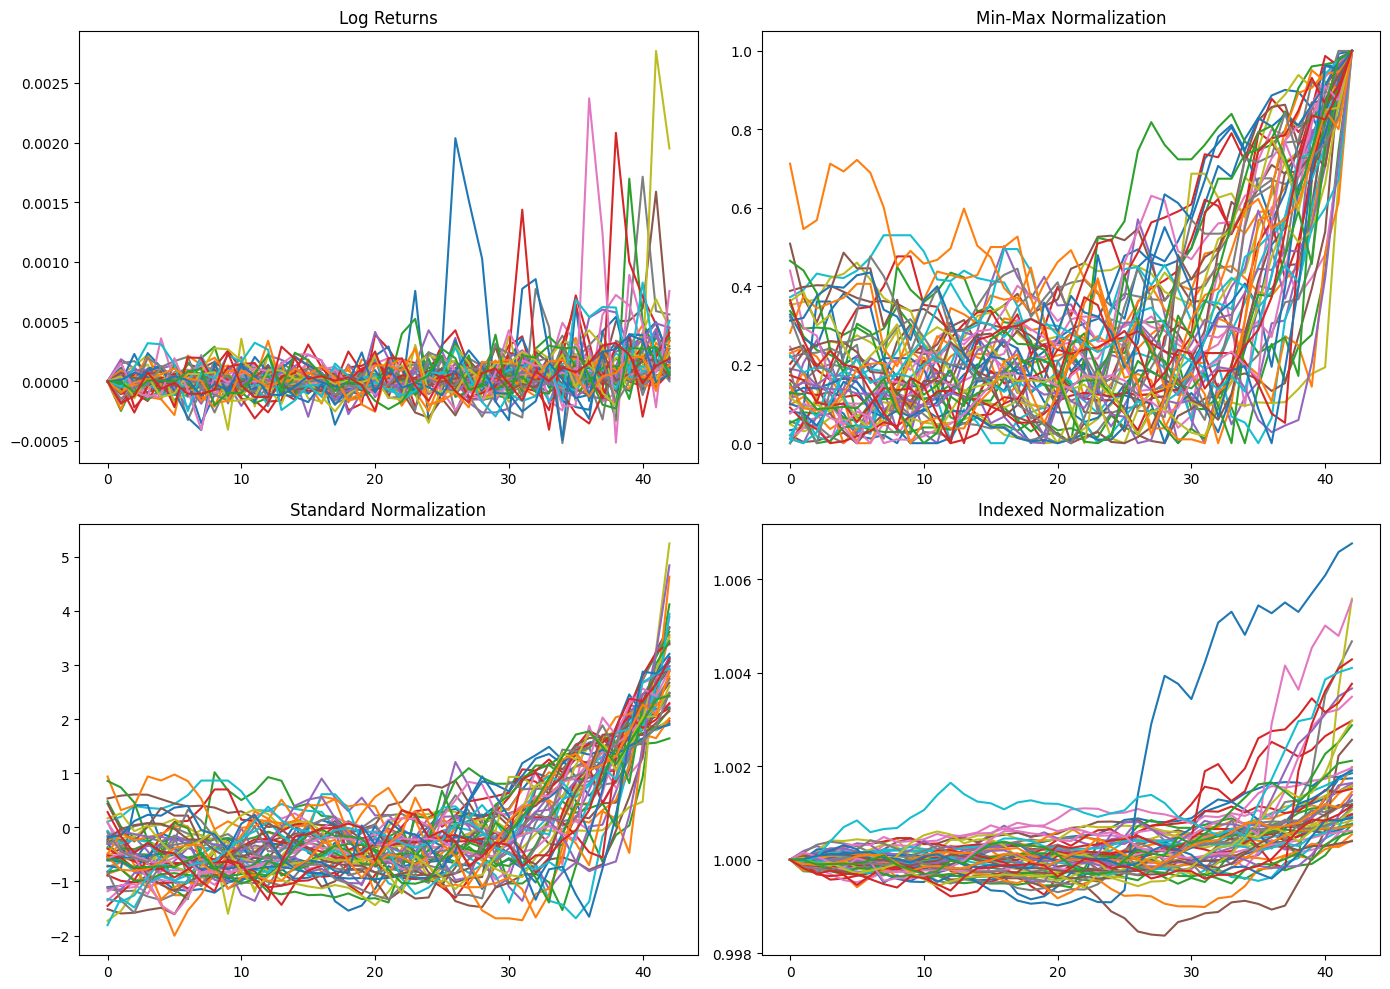

In [ ]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

def calculate_log_returns(arr):
    shifted_arr = np.roll(arr, 1)
    shifted_arr[0] = arr[0]
    return np.log(arr / shifted_arr)

def normalize_min_max(arr):
    scaler = MinMaxScaler()
    return scaler.fit_transform(arr.reshape(-1, 1)).flatten()

def normalize_standard(arr):
    scaler = StandardScaler()
    return scaler.fit_transform(arr.reshape(-1, 1)).flatten()

def normalize_indexed(arr):
    return arr / arr[0]

import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 10))
axes = axes.flatten()

colorIdx = 0;
for idx, hl2 in enumerate(training_data):
  if training_labels[idx] != 1:
    continue
  log_returns = calculate_log_returns(hl2)
  min_max = normalize_min_max(hl2)
  standard = normalize_standard(hl2)
  indexed = normalize_indexed(hl2)

  # Plot each normalization
  axes[0].plot(range(len(hl2)), log_returns, label=f'Dataset {idx}')
  axes[1].plot(range(len(hl2)), min_max, label=f'Dataset {idx}')
  axes[2].plot(range(len(hl2)), standard, label=f'Dataset {idx}')
  axes[3].plot(range(len(hl2)), indexed, label=f'Dataset {idx}')

# Set titles and legends for each subplot
axes[0].set_title('Log Returns')
#axes[0].legend(loc='upper right')

axes[1].set_title('Min-Max Normalization')
#axes[1].legend(loc='upper right')

axes[2].set_title('Standard Normalization')
#axes[2].legend(loc='upper right')

axes[3].set_title('Indexed Normalization')
#axes[3].legend(loc='upper right')

plt.tight_layout()
plt.show()

**Example 3** Visualizing entire dataset divided by pattern class

Training Data Shape: (137, 43)
Training Labels Shape: (137,)
Test Data Shape: (34, 43)
Test Labels Shape: (34,)


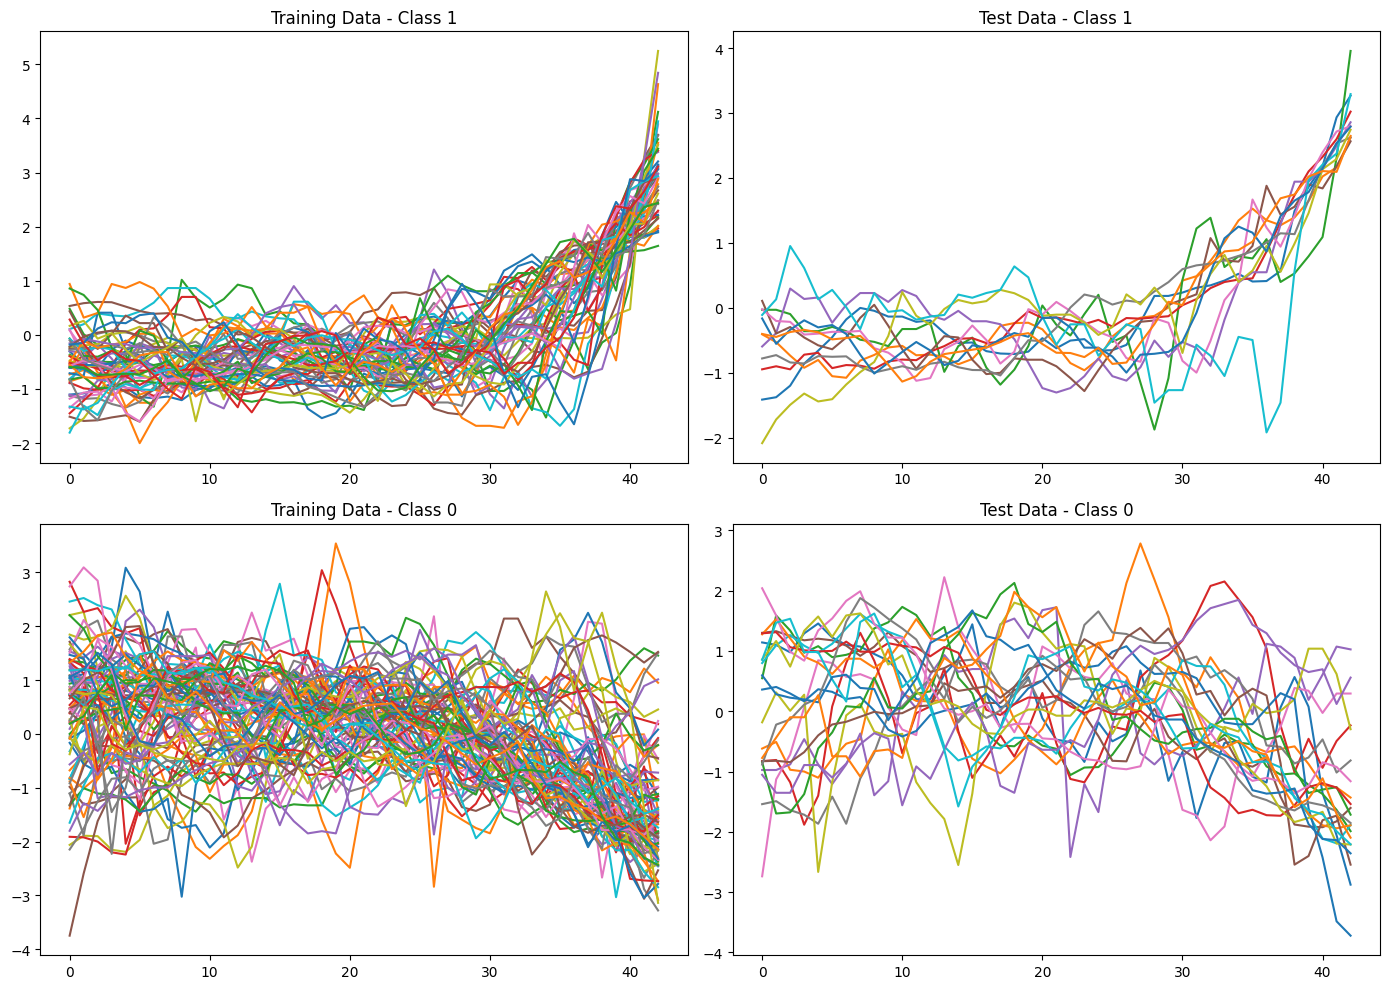

In [ ]:
import os
import re
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

def normalize_standard(np_array):
    scaler = StandardScaler()
    np_array_reshaped = np_array.reshape(-1, 1)
    normalized_array = scaler.fit_transform(np_array_reshaped).flatten()
    return normalized_array

def find_dataset_file(postfix):
    escaped_postfix = re.escape(postfix)
    pattern = rf'^dataset_\d{{4}}\.\d{{2}}\.\d{{2}} \d{{2}}\.\d{{2}}\.\d{{2}}_{escaped_postfix}\.csv$'

    matched_files = []

    for filename in os.listdir('.'):
        if re.match(pattern, filename):
            matched_files.append(filename)

    if len(matched_files) == 1:
        return matched_files[0]
    elif len(matched_files) > 1:
        raise Exception("Multiple report files with specified postfix found.")
    else:
        raise Exception("No files with specified postfix found.")

def load_data_from_file(filename):
    data = []
    labels = []
    dataset_len = 0

    with open(filename, 'r') as file:
        for line in file:
            mp_values, class_label, set_len = parse_dataset_line(line)
            if mp_values is not None:
                if dataset_len == 0: dataset_len = set_len
                elif dataset_len != set_len: print("Incorrect set size")
                data.append(normalize_standard(np.array(mp_values))) # added normalization here
                labels.append(class_label)

    return np.array(data), np.array(labels), dataset_len

def parse_dataset_line(line):
    data_line = line.strip().split('::')
    if len(data_line) == 3:
        ohlc_data_string = data_line[1]
        class_label = int(data_line[2])

        # Extract individual OHLC values
        ohlc_values = []
        entries = ohlc_data_string.split('],[')
        for entry in entries:
            # Extract and convert O, H, L, C values
            d, o, h, l, c = entry.replace('[', '').replace(']', '').replace(' ','').split(',')
            med_price = (float(h) + float(l)) / 2.0
            ohlc_values.append(med_price)
        return ohlc_values, class_label, len(ohlc_values)
    return None, None

filename_training = find_dataset_file("training")
training_data, training_labels, training_len = load_data_from_file(filename_training)

print("Training Data Shape:", training_data.shape)
print("Training Labels Shape:", training_labels.shape)

filename_test = find_dataset_file("test")
test_data, test_labels, test_len = load_data_from_file(filename_test)

# Dataset len check
if training_len != test_len: raise Exception("Training and test datasets have different length")

print("Test Data Shape:", test_data.shape)
print("Test Labels Shape:", test_labels.shape)

def separate_data_by_class(data, labels, class_label):
    return data[labels == class_label]

def plot_data_by_class(training_data, training_labels, test_data, test_labels):
    # Separate data by class
    train_class_1 = separate_data_by_class(training_data, training_labels, 1)
    train_class_0 = separate_data_by_class(training_data, training_labels, 0)
    test_class_1 = separate_data_by_class(test_data, test_labels, 1)
    test_class_0 = separate_data_by_class(test_data, test_labels, 0)

    # Setup the 2x2 plot grid
    fig, axs = plt.subplots(2, 2, figsize=(14, 10))

    # Plot training data for class 1
    for data in train_class_1:
        axs[0, 0].plot(data, label='Class 1 Training')
    axs[0, 0].set_title('Training Data - Class 1')

    # Plot training data for class 0
    for data in train_class_0:
        axs[1, 0].plot(data, label='Class 0 Training')
    axs[1, 0].set_title('Training Data - Class 0')

    # Plot test data for class 1
    for data in test_class_1:
        axs[0, 1].plot(data, label='Class 1 Test')
    axs[0, 1].set_title('Test Data - Class 1')

    # Plot test data for class 0
    for data in test_class_0:
        axs[1, 1].plot(data, label='Class 0 Test')
    axs[1, 1].set_title('Test Data - Class 0')
    plt.tight_layout()
    plt.show()

plot_data_by_class(training_data, training_labels, test_data, test_labels)
print("")

**Example 4** Training a model with one hidden layer. ***To initialize train and validation data collections run Example 3***

Epoch 1/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.7382 - loss: 0.5209 - val_accuracy: 0.9412 - val_loss: 0.2565
Epoch 2/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8942 - loss: 0.3315 - val_accuracy: 0.9412 - val_loss: 0.1790
Epoch 3/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9182 - loss: 0.2378 - val_accuracy: 0.9412 - val_loss: 0.1404
Epoch 4/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9480 - loss: 0.1819 - val_accuracy: 0.9412 - val_loss: 0.1170
Epoch 5/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9480 - loss: 0.1449 - val_accuracy: 0.9706 - val_loss: 0.1017
Epoch 6/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9480 - loss: 0.1191 - val_accuracy: 0.9706 - val_loss: 0.0920
Epoch 7/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9529 - loss: 0.1005 - val_accuracy: 0.9706 - val_loss: 0.0857
Epoch 8/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9751 - loss: 0.0862 - val_accuracy: 0.9706 - val_los

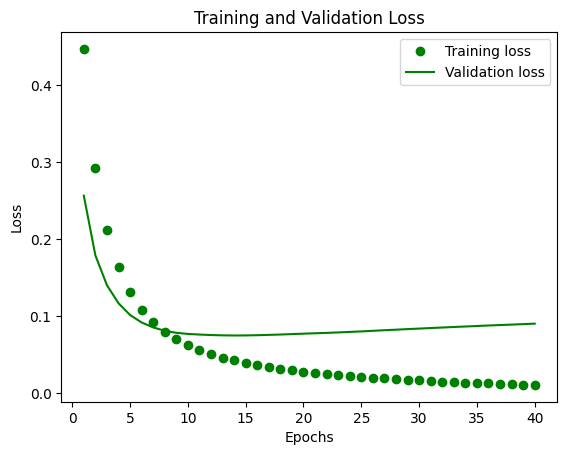

In [ ]:
import tensorflow as tf
import numpy as np
import random

from keras.api.models import Sequential
from keras.api.layers import Input, Dense, Dropout
from keras.api.metrics import Precision, Recall
from keras.api.callbacks import EarlyStopping

# Set the random seed for TensorFlow
def reset_random_seeds(seed_value=4):
    tf.random.set_seed(seed_value)  # TensorFlow's random seed
    np.random.seed(seed_value)      # NumPy's random seed
    random.seed(seed_value)         # Python random library's seed

reset_random_seeds()

# Define the model
model = Sequential([
    Input(shape=(training_len,)),  # Input layer
    Dense(50, activation='relu'),  # Hidden layer
    Dense(1, activation='sigmoid')  # Output layer: sigmoid for binary classification
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Start training process
history = model.fit(training_data, training_labels,
                    epochs=40, batch_size=10,
                    validation_data=(test_data, test_labels))

# Accessing the data from the history object
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

# Plotting
plt.figure()
plt.plot(epochs, loss, 'go', label='Training loss')  # 'bo' means "blue dot"
plt.plot(epochs, val_loss, 'g', label='Validation loss')  # 'b' means "solid blue line"
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

**Example 5** Models with two hidden layers and dropout layers. ***To initialize train and validation data collections run Example 3***

Epoch 1/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.6785 - loss: 0.6110 - val_accuracy: 0.8824 - val_loss: 0.2788
Epoch 2/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9390 - loss: 0.2666 - val_accuracy: 0.9412 - val_loss: 0.1401
Epoch 3/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9513 - loss: 0.1658 - val_accuracy: 1.0000 - val_loss: 0.0834
Epoch 4/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9768 - loss: 0.1013 - val_accuracy: 1.0000 - val_loss: 0.0583
Epoch 5/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9908 - loss: 0.0681 - val_accuracy: 1.0000 - val_loss: 0.0453
Epoch 6/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9867 - loss: 0.0629 - val_accuracy: 1.0000 - val_loss: 0.0381
Epoch 7/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9942 - loss: 0.0438 - val_accuracy: 1.0000 - val_loss: 0.0345
Epoch 8/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9942 - loss: 0.0342 - val_accuracy: 0.9706 - val_loss

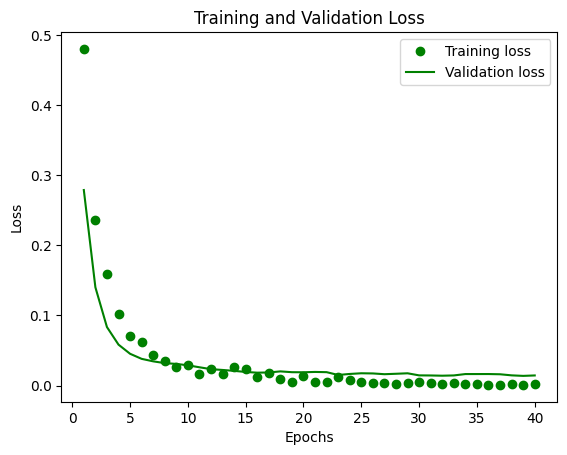

In [ ]:
import tensorflow as tf
import numpy as np
import random

from keras.api.models import Sequential
from keras.api.layers import Input, Dense, Dropout
from keras.api.metrics import Precision, Recall
from keras.api.callbacks import EarlyStopping

# Set the random seed for TensorFlow
def reset_random_seeds(seed_value=4):
    tf.random.set_seed(seed_value)  # TensorFlow's random seed
    np.random.seed(seed_value)      # NumPy's random seed
    random.seed(seed_value)         # Python random library's seed

reset_random_seeds()

# Define the model
model = Sequential([
    Input(shape=(training_len,)),  # Input layer
    Dense(100, activation='relu'), # First hidden layer
    Dropout(0.2),                  # Dropout layer
    Dense(50, activation='relu'),  # Second hidden layer
    Dropout(0.2),                  # Dropout layer
    Dense(1, activation='sigmoid') # Output layer: sigmoid for binary classification
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Early stopping monitor
early_stopping = EarlyStopping(
    monitor='val_loss',      # Monitor validation loss
    min_delta=0.001,         # Minimum change to qualify as an improvement
    patience=10,             # Stop after 10 epochs without improvement
    verbose=1,               # Print messages when stopping
    mode='min',              # Stop when the monitored quantity has stopped decreasing
    restore_best_weights=True  # Restore model weights from the best epoch
)

# Train the model
history = model.fit(training_data, training_labels,
                    epochs=40, batch_size=10,
                    validation_data=(test_data, test_labels),
                    callbacks=[early_stopping])

best_epoch = early_stopping.best_epoch
best_val_loss = history.history['val_loss'][best_epoch]
model_path = f'model_epoch_{(best_epoch + 1):02d}_vl_{best_val_loss:.4f}.keras'
model.save(model_path, overwrite=True, zipped=True)

# Accessing the data from the history object
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

# Plotting
plt.figure()
plt.plot(epochs, loss, 'go', label='Training loss')  # 'bo' means "blue dot"
plt.plot(epochs, val_loss, 'g', label='Validation loss')  # 'b' means "solid blue line"
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()